In [1]:
#IMPORT DELLE LIBRERIE
import numpy as np 
import os
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import zipfile

import cv2
import os
import glob
import gc

import skimage.transform as trans
from skimage import io, color
from skimage.util import random_noise

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

from sklearn.datasets import fetch_lfw_people
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
#DOWNLOAD DEL DATASET
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

mkdir: cannot create directory ‘data_faces’: File exists


In [3]:
#UNZIP DEL DATASET
with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

In [4]:
#FUNZIONE PER CARICARE IN MEMORIA LE IMMAGINI
def read_images(img_dir, xdim, ydim, nmax=50000) :
    label = 0
    label_names = []
    X = []
    y=[]
    for dirname in os.listdir(img_dir):
        print(dirname)
        label_names.append(dirname)
        data_path = os.path.join(img_dir + "/" + dirname,'*g')
        files = glob.glob(data_path)
        n=0
        for f1 in files:
            if n>=nmax : break
            img = cv2.imread(f1) 
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
            img = cv2.resize(img, (xdim,ydim))
            X.append(np.array(img)) 
            n=n+1
        print(n,' images lues')
    X = np.array(X)
    gc.collect() 
    return X

In [5]:
#CARICO IN MEMORIA 100000 IMMAGINI
X= read_images("data_faces", 64, 64, 100000)

img_align_celeba
100000  images lues


In [6]:
#SPLIT DEL DATASET PER IL TEST SET
X_train, X_test = train_test_split(X,
    test_size=0.2)

#SPLIT DEL DATASET PER IL VALIDATION SET
X_train, X_val = train_test_split(X_train, 
    test_size=0.1)

#MODIFICA DI COME VENGONO SALVATE LE IMMAGINI IN MEMORIA
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_val = X_val.astype('float32') / 255

In [7]:
#DIMENSIONI DEL TRAINING SET
X_train.shape

(72000, 64, 64, 3)

In [8]:
#DIMENSIONI DEL TEST SET
X_test.shape

(20000, 64, 64, 3)

In [9]:
#DIMENSIONI DEL VALIDATION SET
X_val.shape

(8000, 64, 64, 3)

In [10]:
X_train_1=X_train[36000:]
X_train_2=X_train[:36000]

In [13]:
#AGGIUNGIAMO IL RUMORE ALLE IMMAGINI DEL TRAINING SET
noise_factor = 0.2

X_train_1_noisy = random_noise(X_train_1, mode="s&p",clip=True, amount=noise_factor)
X_train_2_noisy = random_noise(X_train_2, mode="s&p",clip=True, amount=noise_factor)
X_train_noisy=np.concatenate((X_train_2_noisy, X_train_1_noisy), axis=0)

In [23]:
#PULIZIA MEMORIA
X_train_1=np.delete
X_train_2=np.delete
X_train_1_noisy=np.delete
X_train_2_noisy=np.delete

In [26]:
#AGGIUNGIAMO IL RUMORE ALLE IMMAGINI DEL TEST SET E DEL VALIDATION SET
X_test_noisy = random_noise(X_test, mode="s&p",clip=True, amount=noise_factor)
X_val_noisy = random_noise(X_val, mode="s&p",clip=True, amount=noise_factor)

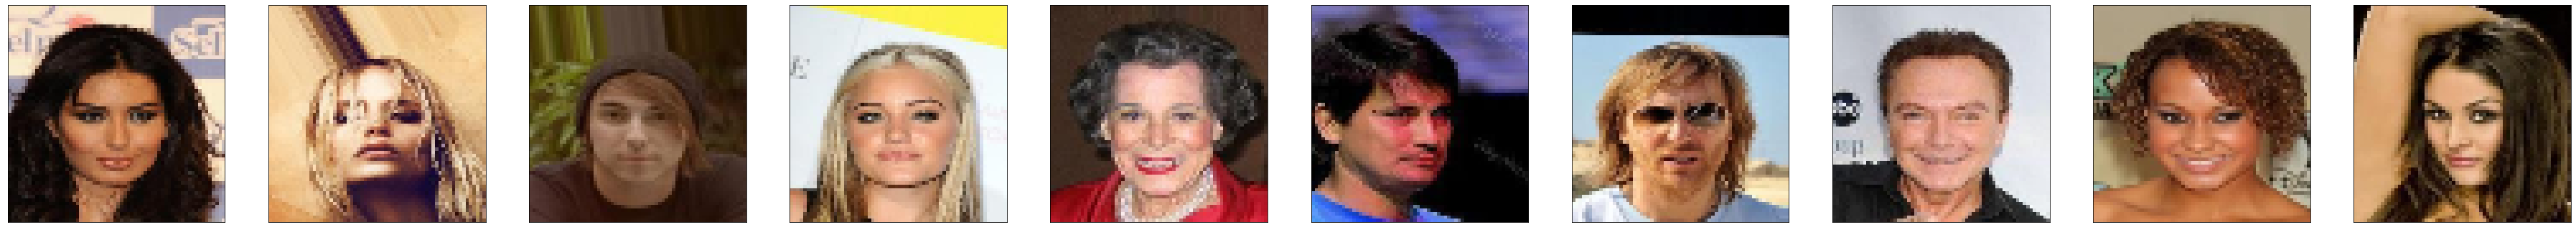

In [24]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TRAINING SET
n = 10

plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_train[i].reshape(64, 64,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

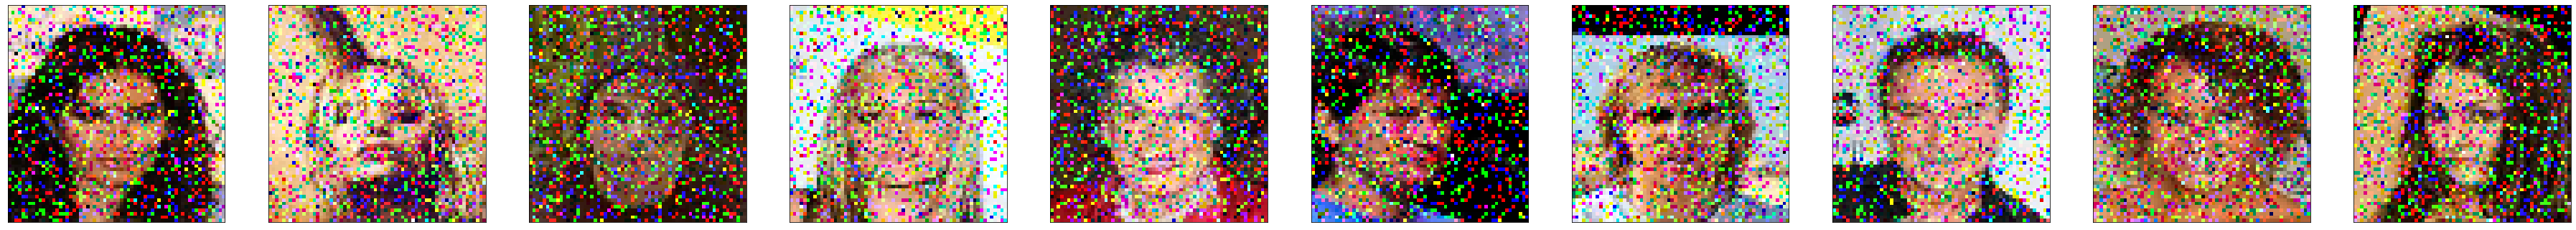

In [25]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TRAINING SET COL RUMORE
n = 10

plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_train_noisy[i].reshape(64, 64,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [28]:
#MODELLO U-NET
input_size = X_train.shape[1:]
inputs = Input(input_size)
conv1 = Conv2D(64,(3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(64,(3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D((2,2))(conv1) 
conv2 = Conv2D(128,(3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128,(3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D((2,2))(conv2)
conv3 = Conv2D(256,(3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256,(3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D((2,2))(conv3)   
conv4 = Conv2D(512,(3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512,(3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D((2,2))(drop4)

conv5 = Conv2D(1024,(3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024,(3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([up6, drop4], axis = 3)
conv6 = Conv2D(512,(3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512,(3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv6)
    
up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([up7, conv3], axis = 3)
conv7 = Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv7)
    
up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([up8, conv2], axis = 3)
conv8 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv8)
    
up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([up9, conv1], axis = 3)
conv9 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv9)

conv10 = Conv2D(3, (1,1), padding='same', activation='sigmoid')(conv9)

model = Model(inputs, conv10)

model.compile(optimizer = Adam(lr = 1e-4), loss = 'mse')

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 64)   36928       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 64)   0           ['conv2d_1[0][0]']               
                                                                                              

In [30]:
#TRAINING DEL MODELLO
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=3)
history = model.fit(X_train_noisy, X_train, epochs=100, batch_size=16, validation_data=(X_val_noisy,X_val), callbacks=[callback])

Epoch 1/100
4500/4500 [==============================] - 466s 101ms/step - loss: 0.0051 - val_loss: 0.0025
Epoch 2/100
4500/4500 [==============================] - 455s 101ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 3/100
4500/4500 [==============================] - 455s 101ms/step - loss: 8.6694e-04 - val_loss: 6.7466e-04
Epoch 4/100
4500/4500 [==============================] - 454s 101ms/step - loss: 5.7950e-04 - val_loss: 4.9988e-04
Epoch 5/100
4500/4500 [==============================] - 454s 101ms/step - loss: 4.4371e-04 - val_loss: 5.7851e-04
Epoch 6/100
4500/4500 [==============================] - 454s 101ms/step - loss: 3.6200e-04 - val_loss: 3.2225e-04
Epoch 7/100
4500/4500 [==============================] - 454s 101ms/step - loss: 3.0933e-04 - val_loss: 4.3553e-04
Epoch 8/100
4500/4500 [==============================] - 453s 101ms/step - loss: 2.7058e-04 - val_loss: 2.5209e-04
Epoch 9/100
4500/4500 [==============================] - 454s 101ms/step - loss: 2.4240e-04 - va

In [31]:
#TEST DEL MODELLO SUL TEST SET
predict = model.predict(X_test_noisy)

625/625 [==============================] - 27s 41ms/step


In [32]:
predict.shape

(20000, 64, 64, 3)

In [33]:
n=10

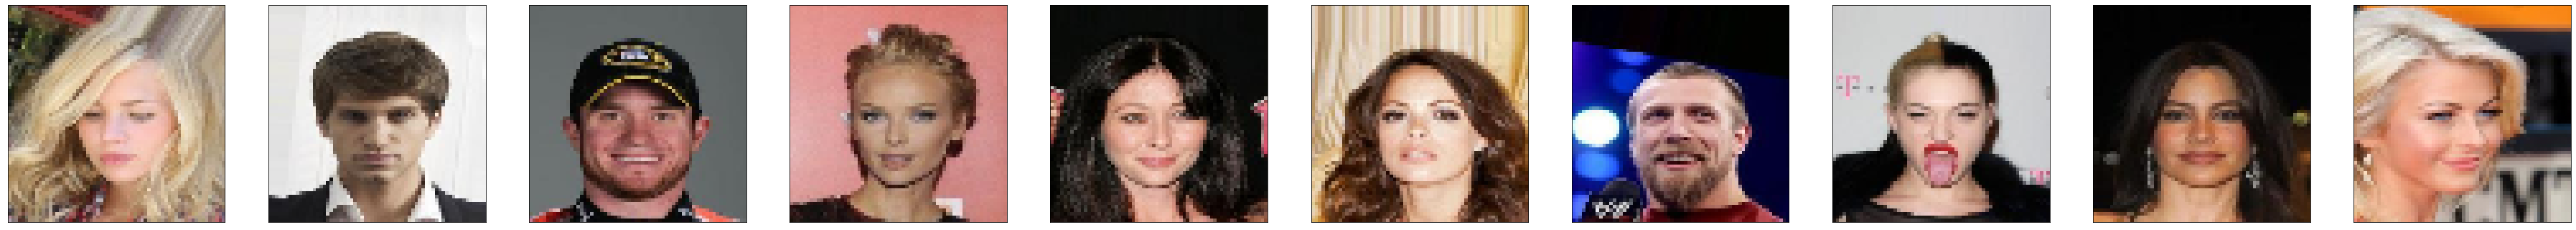

In [34]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TEST SET
plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_test[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

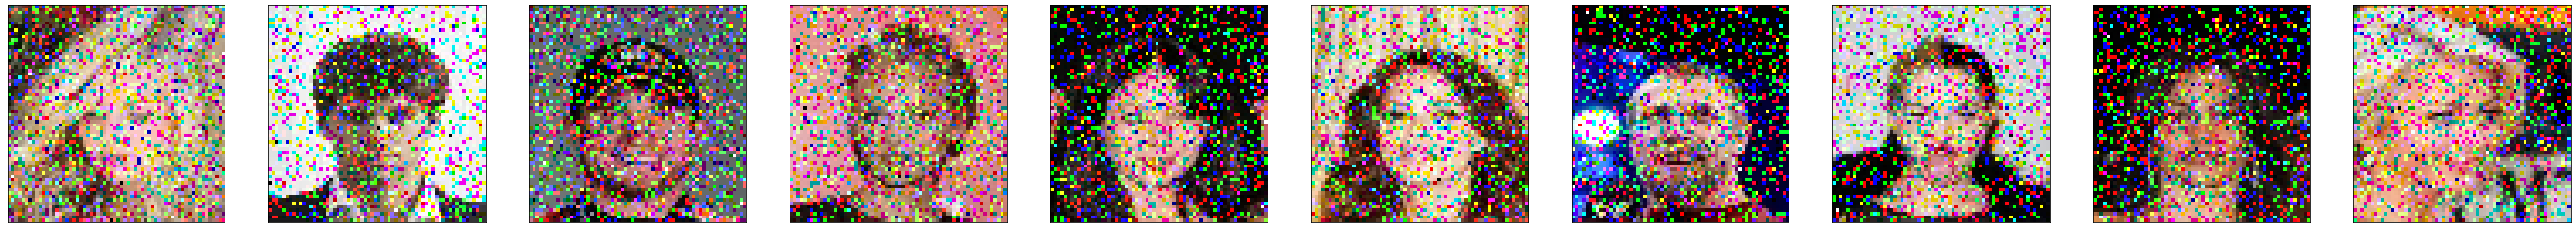

In [35]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TEST SET COL RUMORE
plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_test_noisy[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

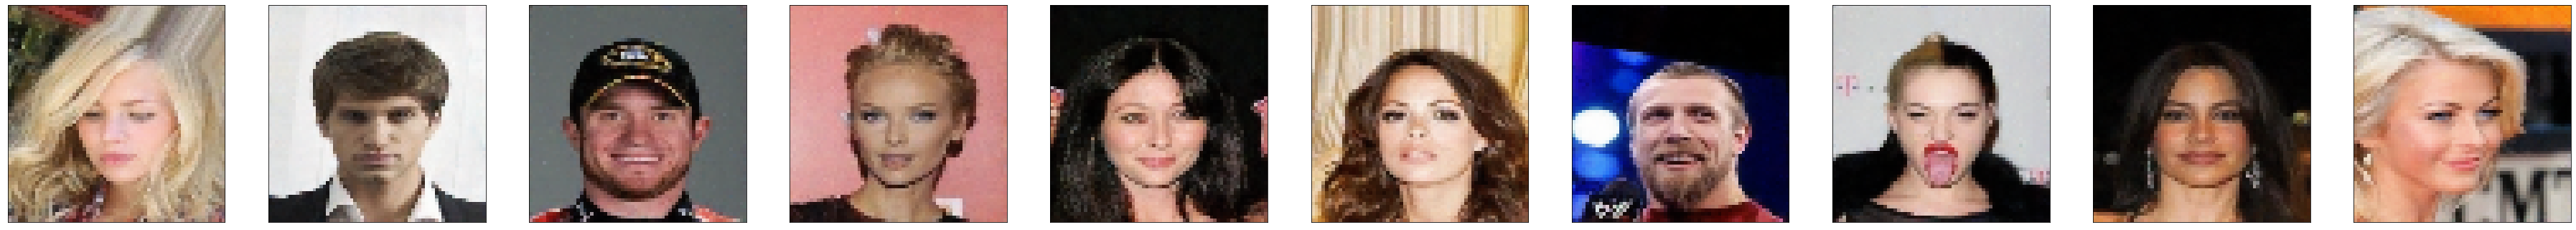

In [36]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TEST SET SENZA RUMORE (OUTPUT DELLA UNET)
plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(predict[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [37]:
NUMBER_OF_TEST_IMAGES = len(X_test)

mse = mean_squared_error(X_test.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3), predict.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3))
mae = mean_absolute_error(X_test.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3), predict.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3))
rmse = np.sqrt(mean_squared_error(X_test.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3), predict.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3)))

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 0.00020733786
Mean Absolute Error: 0.008774719
Root Mean Squared Error: 0.014399231


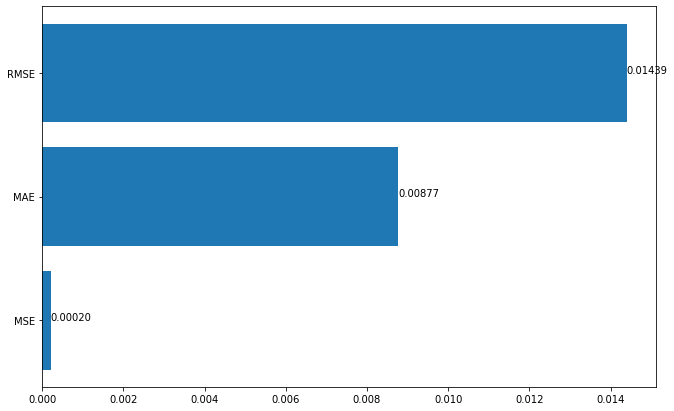

In [38]:
plt.figure(figsize = (11,7))
x = ["MSE","MAE","RMSE"]
y = [mse,mae,rmse]
plt.barh(x, y)
  
for index, value in enumerate(y):
    plt.text(value, index,
             str(value)[:7])
plt.show()